In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib as mpl
import numpy as np
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
from shapely import Point
import osmnx as ox
from pyogrio.errors import DataSourceError

ox.settings.log_console = False
ox.settings.use_cache = True

mpl.rcParams["svg.hashsalt"] = "42"

metadata = {
    "png": {"Author": "Gergő Pintér", "CreationDate": None, "Copyright": "CC BY 4.0"},
    "svg": {"Creator": "Gergő Pintér", "Date": None, "Rights": "CC BY 4.0"},
}

In [2]:
boundary = gpd.read_file("../data/boundary.geojson")

In [3]:
try:
    bud = gpd.read_file("../data/weeplace/budapest.geojson")
except DataSourceError:
    # runs 13s
    weeplace = pd.read_csv("../data/weeplace/weeplace_checkins.csv")
    bud = weeplace[(weeplace["lon"].between(18.95, 19.3)) & (weeplace["lat"].between(47.35, 47.65))].copy()
    bud = gpd.GeoDataFrame(bud, geometry=gpd.points_from_xy(bud["lon"], bud["lat"]), crs=4326)
    bud = bud[bud.geometry.within(boundary.geometry[0])].copy()
    bud.to_file("../data/weeplace/budapest.geojson")

In [4]:
bud.drop_duplicates(["lon", "lat"], inplace=True)
bud.to_crs(23700, inplace=True)

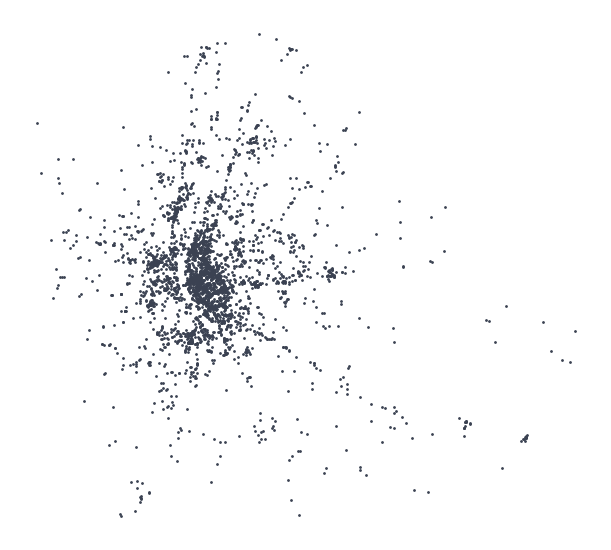

In [5]:
fig, ax = plt.subplots(layout="constrained", figsize=(6, 6))
ax.margins(0.05)
ax.axis("off")
bud.plot(ax=ax, markersize=1, color="#3b4252")
for i in ["png", "svg"]:
    fig.savefig(f"../figures/bud_all.{i}", facecolor="none", dpi=300, metadata=metadata[i])

full_limits = {"x": ax.get_xlim(), "y": ax.get_ylim()}

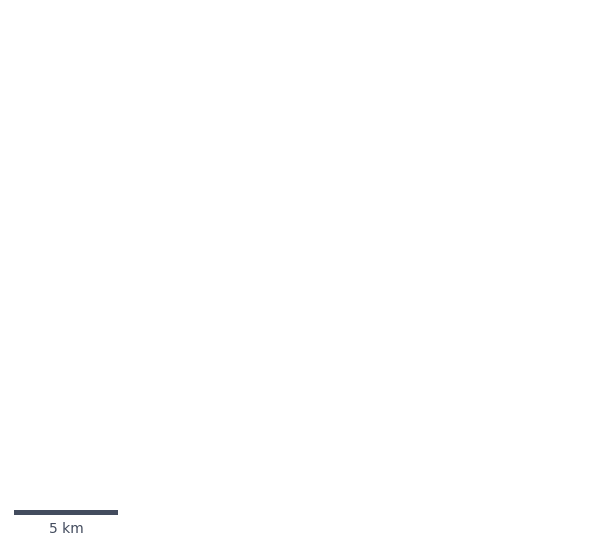

In [27]:
fig, ax = plt.subplots(layout="constrained", figsize=(6, 6))
ax.set_aspect(1)
ax.margins(0.05)
ax.axis("off")
ax.set_xlim(full_limits["x"])
ax.set_ylim(full_limits["y"])
ax.add_artist(ScaleBar(1, units="m", location="lower left", box_alpha=0, color="#434c5e"))
for i in ["png", "svg"]:
    fig.savefig(f"../figures/bud_empty.{i}", facecolor="none", dpi=300, metadata=metadata[i])

In [7]:
p = Point(19.0575, 47.5045)
circle_gps = gpd.GeoDataFrame(geometry=[p], crs=4326).to_crs(23700).buffer(100).to_crs(4326).geometry[0]
circle_gps_gdf = gpd.GeoDataFrame(geometry=[circle_gps], crs=4326)
circle_eov_gdf = circle_gps_gdf.to_crs(23700)
circle_eov = circle_eov_gdf.geometry[0]

In [8]:
ecluded_placeids = ['sandokan-lisboa', 'hairpoint', 'b-city-pub-budapest', 'cheho-pub', 'noiret', 'la-cantina-dell-opera', 'the-kaledonia-budapest']
selected = bud[bud.geometry.within(circle_eov)].query("~placeid.isin(@ecluded_placeids)").copy()
selected.drop_duplicates("placeid", inplace=True)

20

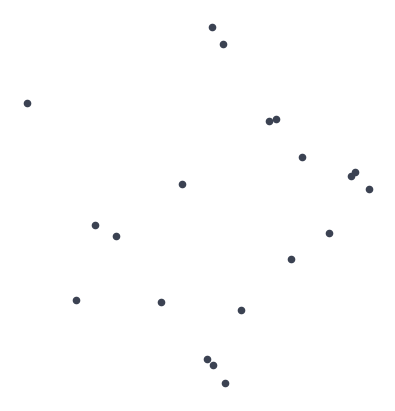

In [9]:
fig, ax = plt.subplots(layout="constrained", figsize=(4, 4))
ax.margins(0.05)
ax.axis("off")
selected.plot(ax=ax, markersize=20, color="#3b4252")
len(selected)

20


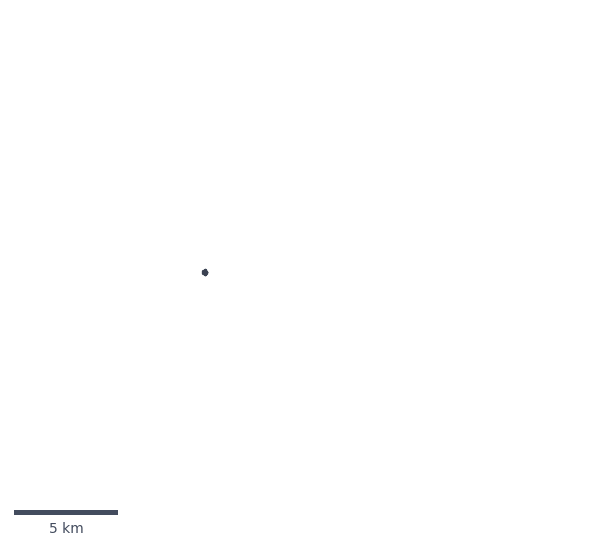

In [26]:
fig, ax = plt.subplots(layout="constrained", figsize=(6, 6))
ax.set_aspect(1)
ax.margins(0.05)
ax.axis("off")
ax.set_xlim(full_limits["x"])
ax.set_ylim(full_limits["y"])
selected.plot(ax=ax, markersize=2, color="#3b4252")
ax.add_artist(ScaleBar(1, units="m", location="lower left", box_alpha=0, color="#434c5e"))
print(len(selected))
for i in ["png", "svg"]:
    fig.savefig(f"../figures/bud_selected_only.{i}", facecolor="none", dpi=300, metadata=metadata[i])


37


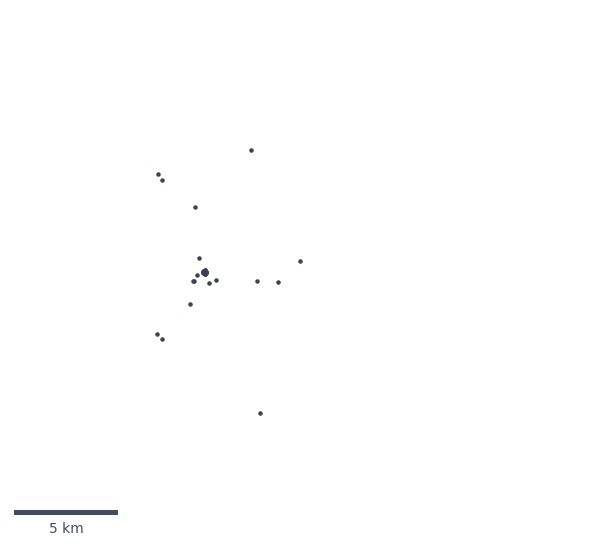

In [11]:
np.random.seed(42)
n = round(len(bud)*0.005)
sample = bud.sample(n).copy()
fig, ax = plt.subplots(layout="constrained", figsize=(6, 6))
ax.set_aspect(1)
ax.margins(0.05)
ax.axis("off")
ax.set_xlim(full_limits["x"])
ax.set_ylim(full_limits["y"])
selected.plot(ax=ax, markersize=5, color="#3b4252")
sample.plot(ax=ax, markersize=5, color="#3b4252")
ax.add_artist(ScaleBar(1, units="m", location="lower left", box_alpha=0, color="#434c5e"))
print(n + len(selected))
for i in ["png", "svg"]:
    fig.savefig(f"../figures/bud_05pct.{i}", facecolor="none", dpi=300, metadata=metadata[i])


In [ ]:
# bbox = gpd.GeoDataFrame(geometry=[circle.envelope], crs=4326)

37


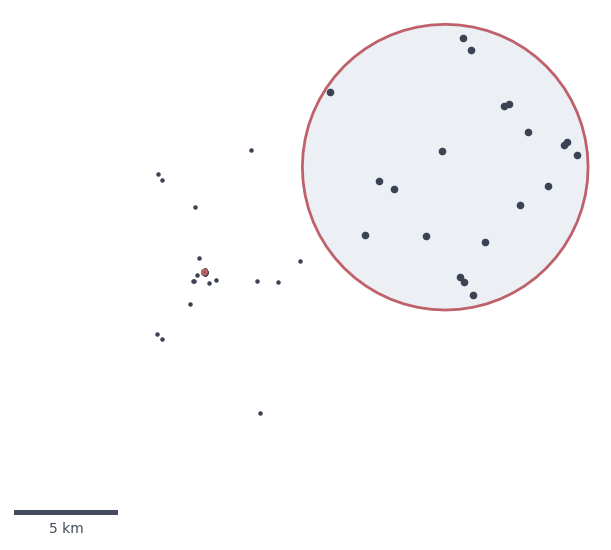

In [12]:
np.random.seed(42)
n = round(len(bud)*0.005)
sample = bud.sample(n).copy()
fig, ax = plt.subplots(layout="constrained", figsize=(6, 6))
ax.set_aspect(1)
ax.margins(0.05)
ax.axis("off")
ax.set_xlim(full_limits["x"])
ax.set_ylim(full_limits["y"])
selected.plot(ax=ax, markersize=5, color="#3b4252")
sample.plot(ax=ax, markersize=5, color="#3b4252")
circle_eov_gdf.plot(ax=ax, fc="none", ec="#bf616a", lw=2)
iax = inset_axes(
    ax,
    width=3,
    height=3,  # inch
    bbox_transform=ax.transAxes,  # relative axes coordinates
    bbox_to_anchor=(1, 1),
)
# bbox.plot(ax=iax, fc="none", ec="#bf616a", lw=2)
circle_eov_gdf.plot(ax=iax, fc="#eceff4", ec="#bf616a", lw=2)
selected.plot(ax=iax, markersize=20, color="#3b4252")
iax.margins(0.025)
iax.axis("off")
ax.add_artist(ScaleBar(1, units="m", location="lower left", box_alpha=0, color="#434c5e"))
print(n + len(selected))
for i in ["png", "svg"]:
    fig.savefig(f"../figures/bud_05pct_zoom.{i}", facecolor="none", dpi=300, metadata=metadata[i])


In [15]:
buildings = ox.features_from_point((p.y, p.x), tags = {"building": True} , dist=200)
buildings = buildings[buildings.geom_type != 'Point'].copy()
buildings.to_crs(23700, inplace=True)
streets = ox.features_from_point((p.y, p.x), tags = {"highway": True} , dist=200)
streets = streets[streets.geom_type != 'Point'].copy()
streets.to_crs(23700, inplace=True)

37


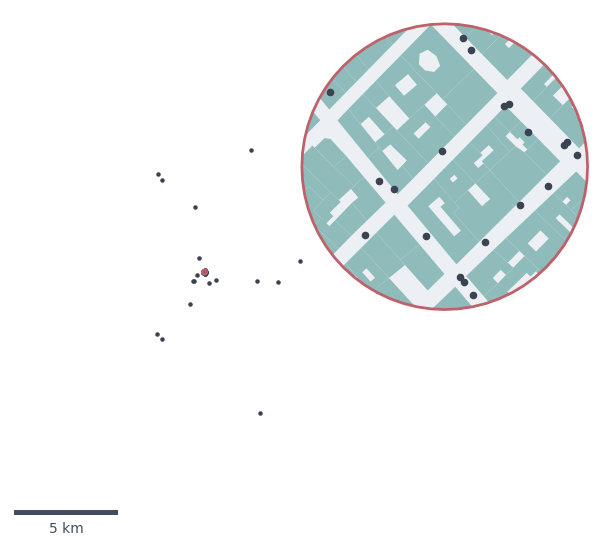

In [16]:
np.random.seed(42)
n = round(len(bud)*0.005)
sample = bud.sample(n).copy()
fig, ax = plt.subplots(layout="constrained", figsize=(6, 6))
ax.set_aspect(1)
ax.margins(0.05)
ax.axis("off")
ax.set_xlim(full_limits["x"])
ax.set_ylim(full_limits["y"])
selected.plot(ax=ax, markersize=5, color="#3b4252")
sample.plot(ax=ax, markersize=5, color="#3b4252")
circle_eov_gdf.plot(ax=ax, fc="none", ec="#bf616a", lw=2)
iax = inset_axes(
    ax,
    width=3,
    height=3,  # inch
    bbox_transform=ax.transAxes,  # relative axes coordinates
    bbox_to_anchor=(1, 1),
)
circle_eov_gdf.plot(ax=iax, fc="#eceff4", ec="none", lw=0)
# gpd.clip(buildings, circle).plot(ax=iax, color="#81a1c1")
gpd.clip(buildings, circle_eov).plot(ax=iax, color="#8fbcbb")
# gpd.clip(streets, circle).plot(ax=iax, color="#d8dee9", lw=8, capstyle="round")
selected.plot(ax=iax, markersize=20, color="#3b4252", zorder=8)
circle_eov_gdf.plot(ax=iax, fc="none", ec="#bf616a", lw=2, zorder=10)
iax.margins(0.025)
iax.axis("off")
ax.add_artist(ScaleBar(1, units="m", location="lower left", box_alpha=0, color="#434c5e"))
print(n + len(selected))
for i in ["png", "svg"]:
    fig.savefig(f"../figures/bud_05pct_zoom_map.{i}", facecolor="none", dpi=300, metadata=metadata[i])

70


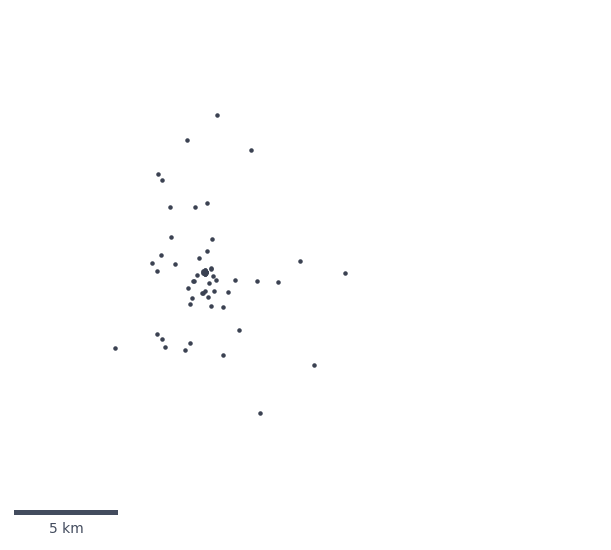

In [20]:
np.random.seed(42)
n = round(len(bud)*0.02-len(selected))
sample = bud.sample(n).copy()
fig, ax = plt.subplots(layout="constrained", figsize=(6, 6))
ax.set_aspect(1)
ax.margins(0.05)
ax.axis("off")
ax.set_xlim(full_limits["x"])
ax.set_ylim(full_limits["y"])
selected.plot(ax=ax, markersize=5, color="#3b4252")
sample.plot(ax=ax, markersize=5, color="#3b4252")
ax.add_artist(ScaleBar(1, units="m", location="lower left", box_alpha=0, color="#434c5e"))
print(n + len(selected))
for i in ["png", "svg"]:
    fig.savefig(f"../figures/bud_2pct.{i}", facecolor="none", dpi=300, metadata=metadata[i])


697


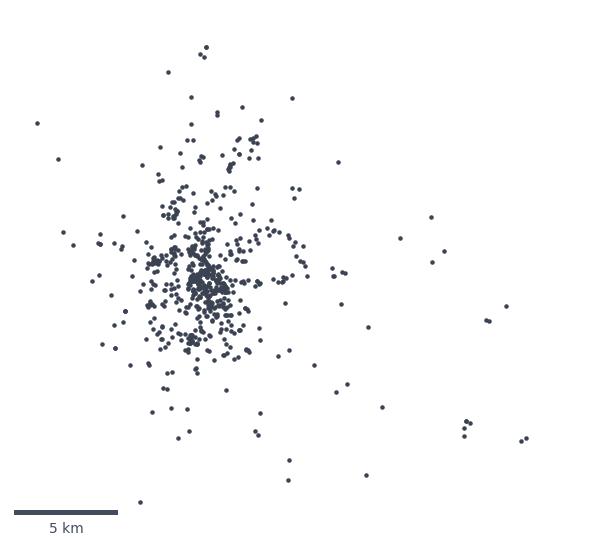

In [21]:
np.random.seed(42)
n = round(len(bud)*0.2-len(selected))
sample = bud.sample(n).copy()
fig, ax = plt.subplots(layout="constrained", figsize=(6, 6))
ax.set_aspect(1)
ax.margins(0.05)
ax.axis("off")
ax.set_xlim(full_limits["x"])
ax.set_ylim(full_limits["y"])
selected.plot(ax=ax, markersize=5, color="#3b4252")
sample.plot(ax=ax, markersize=5, color="#3b4252")
ax.add_artist(ScaleBar(1, units="m", location="lower left", box_alpha=0, color="#434c5e"))
print(n + len(selected))
for i in ["png", "svg"]:
    fig.savefig(f"../figures/bud_20pct.{i}", facecolor="none", dpi=300, metadata=metadata[i])


3485

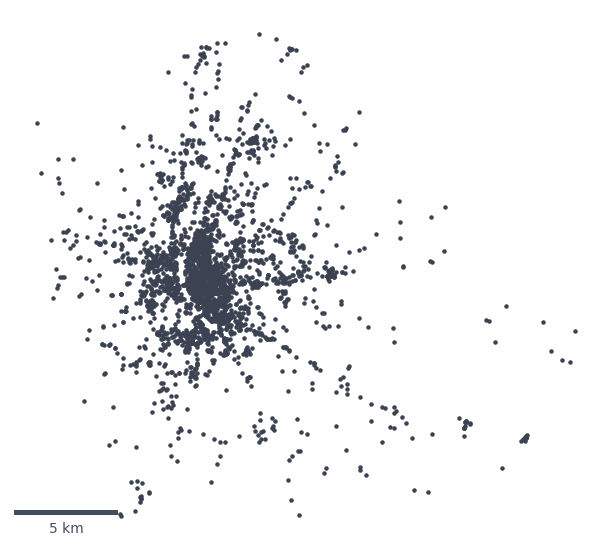

In [22]:
fig, ax = plt.subplots(layout="constrained", figsize=(6, 6))
ax.set_aspect(1)
ax.margins(0.05)
ax.axis("off")
ax.set_xlim(full_limits["x"])
ax.set_ylim(full_limits["y"])
selected.plot(ax=ax, markersize=5, color="#3b4252")
bud.plot(ax=ax, markersize=5, color="#3b4252")
ax.add_artist(ScaleBar(1, units="m", location="lower left", box_alpha=0, color="#434c5e"))
for i in ["png", "svg"]:
    fig.savefig(f"../figures/bud_100pct.{i}", facecolor="none", dpi=300, metadata=metadata[i])
len(bud)